In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [4]:
absa_final_subset = absa_final[:1001]
absa_final_subset

,index,sentence,aspect,sentiment_coded,polarity
0,0,I charge it at night and skip taking the cord ...,cord,2,neutral
1,1,I charge it at night and skip taking the cord ...,battery life,1,positive
2,2,The tech guy then said the service center does...,service center,0,negative
3,3,The tech guy then said the service center does...,"""sales"" team",0,negative
4,4,The tech guy then said the service center does...,tech guy,2,neutral
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,1,positive
997,997,Other than that its a great performing machine...,performing,1,positive
998,998,"Called tech support and got the usual Acer ""We...",software,0,negative
999,999,"Called tech support and got the usual Acer ""We...",software,0,negative


In [9]:
# absa_final_subset.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_SUBSET_1000.csv')

# Baseline 

## OpenAI / GPT

In [10]:
openai_client

### ABSA

In [4]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [ ]:
You classify the sentiment of a specific aspect within a text. 
Example 1:
Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'Mac software', Text: 'Everything is so easy to use, Mac software is just so much simpler than Microsoft software.'

Answer: {'steps':"The sentence “Everything is so easy to use, Mac software is just so much simpler than Microsoft software.” clearly conveys a positive sentiment towards the aspect “Mac software.” 
First, the sentence highlights the overall ease of use with the phrase “so easy to use.” 
This indicates that the person finds the software intuitive and user-friendly, which is a positive expression. 
Then, a direct comparison is made with Microsoft software, stating that “Mac software is just so much simpler.” 
This comparison emphasizes the superiority of Mac software in terms of simplicity. Overall, the positive language (“easy to use,” “simpler”) demonstrates that the person perceives Mac software as more user-friendly and less complicated compared to Microsoft software, resulting in a positive sentiment.",
'final_anwer': positive}

In [36]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role":"system",
                "content":"""
                    You classify the sentiment of a specific aspect within a text. 
                    Example 1:
                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                        Aspect: 'Mac software', Text: 'Everything is so easy to use, Mac software is just so much simpler than Microsoft software.'
                    
                    Answer: {'steps':"The sentence “Everything is so easy to use, Mac software is just so much simpler than Microsoft software.” clearly conveys a positive sentiment towards the aspect “Mac software.” 
                    First, the sentence highlights the overall ease of use with the phrase “so easy to use.” 
                    This indicates that the person finds the software intuitive and user-friendly, which is a positive expression. 
                    Then, a direct comparison is made with Microsoft software, stating that “Mac software is just so much simpler.” 
                    This comparison emphasizes the superiority of Mac software in terms of simplicity. Overall, the positive language (“easy to use,” “simpler”) demonstrates that the person perceives Mac software as more user-friendly and less complicated compared to Microsoft software, resulting in a positive sentiment.",
                    'final_anwer': positive}

                    Example 2:
                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                        Aspect: 'external monitor', Text: 'Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares' 
                    Answer: {'steps': "The sentence “Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares.” expresses a neutral sentiment regarding the aspect “external monitor.” 
                    First, a potential limitation is acknowledged, as the speaker notes that a 13-inch screen is small, particularly for a desktop replacement. 
                    However, this concern is immediately addressed by mentioning the external monitor, with the phrase “but with an external monitor, who cares.” 
                    This suggests that the issue of screen size is resolved by the external monitor, but the tone is indifferent rather than strongly positive or negative. 
                    The external monitor is presented as a practical solution without eliciting strong emotions, leading to a neutral overall sentiment.",
                    'final_answer': neutral}
                    """
                },
                {
                "role": "user",
                 "content": (f"""Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                                  Aspect: {aspect}, Text: {text} 
                                """)
                }
            ],
            temperature = 0.2,
            response_format=CoT
        )
        
        response_content = response.choices[0].message.parsed #response.choices[0].message.content
        result_step = response_content.steps
        final_answer = response_content.final_answer
        print(index, " ", "Label: ",final_answer )            
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df.loc[row_counter] = [index, text, aspect, result_step, final_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   Label:  positive
1   Label:  positive
2   Label:  negative
3   Label:  neutral
4   Label:  negative
5   Label:  positive
6   Label:  positive
7   Label:  positive
8   Label:  positive
9   Label:  positive
10   Label:  positive
11   Label:  positive
12   Label:  positive
13   Label:  positive
14   Label:  positive
15   Label:  negative
16   Label:  negative
17   Label:  negative
18   Label:  negative
19   Label:  negative
20   Label:  negative
21   Label:  negative
22   Label:  positive
23   Label:  positive
24   Label:  neutral
25   Label:  negative
26   Label:  positive
27   Label:  positive
28   Label:  positive
29   Label:  negative
30   Label:  negative
31   Label:  negative
32   Label:  negative
33   Label:  positive
34   Label:  positive
35   Label:  positive
36   Label:  negative
37   Label:  negative
38   Label:  positive
39   Label:  positive
40   Label:  positive
41   Label:  positive
42   Label:  negative
43   Label:  negative
44   Label:  negative
45   Label:  neutral
4

In [37]:
results_gpt_df

,index,sentence,aspect,steps,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[explanation='The sentence ""I charge it at nig...",positive
1,1,I charge it at night and skip taking the cord ...,battery life,"[explanation='The sentence ""I charge it at nig...",positive
2,2,The tech guy then said the service center does...,service center,"[explanation=""The sentence discusses the servi...",negative
3,3,The tech guy then said the service center does...,"""sales"" team","[explanation=""The sentence discusses the servi...",neutral
4,4,The tech guy then said the service center does...,tech guy,"[explanation=""The sentence discusses a situati...",negative
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,"[explanation='The sentence ""iPhotos is an exce...",positive
997,997,Other than that its a great performing machine...,performing,"[explanation='The sentence ""Other than that it...",positive
998,998,"Called tech support and got the usual Acer ""We...",software,"[explanation='The sentence ""Called tech suppor...",negative
999,999,"Called tech support and got the usual Acer ""We...",software,"[explanation='The sentence ""Called tech suppor...",negative


In [38]:
### Datenaufbereitung

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_ver = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_ver['generated_label'] = results_gpt_df_ver['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final = results_gpt_df_ver[results_gpt_df_ver['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].astype(int)

/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_83682/3145298559.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].astype(int)


In [39]:
results_gpt_df_final

,index,sentence,aspect,steps,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[explanation='The sentence ""I charge it at nig...",1
1,1,I charge it at night and skip taking the cord ...,battery life,"[explanation='The sentence ""I charge it at nig...",1
2,2,The tech guy then said the service center does...,service center,"[explanation=""The sentence discusses the servi...",0
3,3,The tech guy then said the service center does...,"""sales"" team","[explanation=""The sentence discusses the servi...",2
4,4,The tech guy then said the service center does...,tech guy,"[explanation=""The sentence discusses a situati...",0
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,"[explanation='The sentence ""iPhotos is an exce...",1
997,997,Other than that its a great performing machine...,performing,"[explanation='The sentence ""Other than that it...",1
998,998,"Called tech support and got the usual Acer ""We...",software,"[explanation='The sentence ""Called tech suppor...",0
999,999,"Called tech support and got the usual Acer ""We...",software,"[explanation='The sentence ""Called tech suppor...",0


In [40]:
# CSV abspeichern 
results_gpt_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_CoT_GPT.csv', encoding='utf-8-sig')


### Evaluation

In [41]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gpt_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.83
Precision (macro): 0.79
Recall (macro): 0.77
F1-Score (macro): 0.77
Confusion Matrix:
[[347   9  22]
 [ 18 400  28]
 [ 52  37  86]]


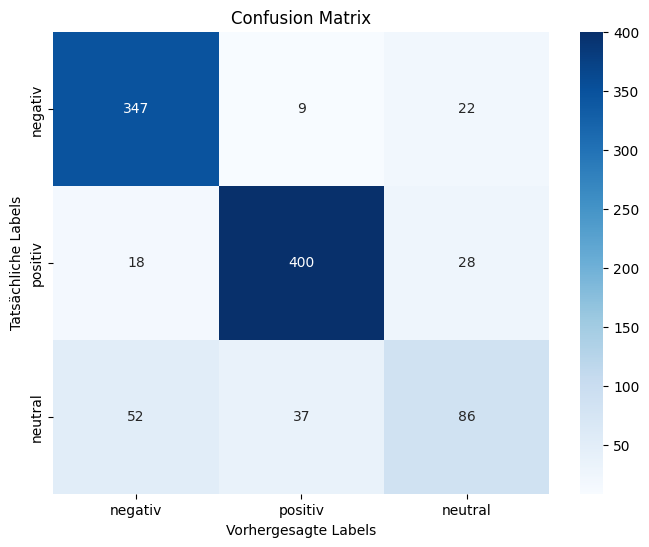

In [42]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

# Zero-Shot

In [17]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df2 = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role":"system",
                "content":"""
                    You classify the sentiment of a specific aspect within a text. 
                    Reason step-by-step by breaking down the analysis for the specified aspect. Explain each step in detail before providing your final answer.

                    """
                },
                {
                "role": "user",
                 "content": (f"""Classify the sentiment for the following aspect in the given text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’]. 
                                  Aspect: {aspect}, Text: {text} 
                                """)
                }
            ],
            temperature = 0.2,
            response_format=CoT
        )
        
        response_content = response.choices[0].message.parsed #response.choices[0].message.content
        result_step = response_content.steps
        final_answer = response_content.final_answer
        print(index, " ", "Label: ",final_answer )            
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df2.loc[row_counter] = [index, text, aspect, result_step, final_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



638   Label:  positive
639   Label:  negative
640   Label:  negative
641   Label:  negative
642   Label:  positive
643   Label:  positive
644   Label:  positive
645   Label:  positive
646   Label:  positive
647   Label:  negative
648   Label:  negative
649   Label:  positive
650   Label:  positive
651   Label:  negative
652   Label:  positive
653   Label:  positive
654   Label:  negative
655   Label:  negative
656   Label:  positive
657   Label:  negative
658   Label:  positive
659   Label:  positive
660   Label:  positive
661   Label:  negative
662   Label:  positive
663   Label:  positive
664   Label:  negative
665   Label:  positive
666   Label:  positive
667   Label:  negative
668   Label:  positive
669   Label:  positive
670   Label:  negative
671   Label:  negative
672   Label:  positive
673   Label:  negative
674   Label:  negative
675   Label:  negative
676   Label:  negative
677   Label:  positive
678   Label:  positive
679   Label:  positive
680   Label:  negative
681   Label

In [23]:
results_gpt_df


,index,sentence,aspect,steps,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[explanation=""First, we identify the aspect we...",positive
1,1,I charge it at night and skip taking the cord ...,battery life,"[explanation=""First, identify the aspect we ar...",positive
2,2,The tech guy then said the service center does...,service center,"[explanation=""First, I identify the aspect bei...",negative
3,3,The tech guy then said the service center does...,"""sales"" team","[explanation='First, I identify the aspect tha...",negative
4,4,The tech guy then said the service center does...,tech guy,"[explanation=""First, we identify the aspect we...",negative
...,...,...,...,...,...
358,996,iPhotos is an excellent program for storing an...,program,"[explanation=""First, we identify the aspect we...",positive
359,997,Other than that its a great performing machine...,performing,"[explanation=""First, we identify the aspect we...",positive
360,998,"Called tech support and got the usual Acer ""We...",software,"[explanation=""First, we identify the aspect we...",negative
361,999,"Called tech support and got the usual Acer ""We...",software,"[explanation=""First, I identify the aspect in ...",negative


### Datenaufbereitung


In [24]:

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_ver = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_ver['generated_label'] = results_gpt_df_ver['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final = results_gpt_df_ver[results_gpt_df_ver['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].astype(int)

/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_97350/3145298559.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gpt_df_ver['generated_label'] = results_gpt_df_ver['generated_label'].replace({


In [25]:

results_gpt_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_ZeroCoT_GPT.csv', encoding='utf-8-sig')



## Eval


In [28]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gpt_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.85
Precision (macro): 0.75
Recall (macro): 0.72
F1-Score (macro): 0.73
Confusion Matrix:
[[133   3   6]
 [  3 162   8]
 [ 17  17  14]]


## Gemini

### SemEval-2014

In [45]:
absa_final_subset = absa_final[:1001]
absa_final_subset

,index,sentence,aspect,sentiment_coded,polarity
0,0,I charge it at night and skip taking the cord ...,cord,2,neutral
1,1,I charge it at night and skip taking the cord ...,battery life,1,positive
2,2,The tech guy then said the service center does...,service center,0,negative
3,3,The tech guy then said the service center does...,"""sales"" team",0,negative
4,4,The tech guy then said the service center does...,tech guy,2,neutral
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,1,positive
997,997,Other than that its a great performing machine...,performing,1,positive
998,998,"Called tech support and got the usual Acer ""We...",software,0,negative
999,999,"Called tech support and got the usual Acer ""We...",software,0,negative


In [46]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""
    Use this JSON Schema: Result = {'steps':str, 'final_answer': str} 
    You classify the sentiment of a specific aspect within a text. 
    Example 1:
    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
        Aspect: 'Mac software', Text: 'Everything is so easy to use, Mac software is just so much simpler than Microsoft software.'
    
    Answer: {'steps':"The sentence “Everything is so easy to use, Mac software is just so much simpler than Microsoft software.” clearly conveys a positive sentiment towards the aspect “Mac software.” 
    First, the sentence highlights the overall ease of use with the phrase “so easy to use.” 
    This indicates that the person finds the software intuitive and user-friendly, which is a positive expression. 
    Then, a direct comparison is made with Microsoft software, stating that “Mac software is just so much simpler.” 
    This comparison emphasizes the superiority of Mac software in terms of simplicity. Overall, the positive language (“easy to use,” “simpler”) demonstrates that the person perceives Mac software as more user-friendly and less complicated compared to Microsoft software, resulting in a positive sentiment.",
    'final_anwer': positive}

    Example 2:
    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
        Aspect: 'external monitor', Text: 'Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares' 
    Answer: {'steps': "The sentence “Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares.” expresses a neutral sentiment regarding the aspect “external monitor.” 
    First, a potential limitation is acknowledged, as the speaker notes that a 13-inch screen is small, particularly for a desktop replacement. 
    However, this concern is immediately addressed by mentioning the external monitor, with the phrase “but with an external monitor, who cares.” 
    This suggests that the issue of screen size is resolved by the external monitor, but the tone is indifferent rather than strongly positive or negative. 
    The external monitor is presented as a practical solution without eliciting strong emotions, leading to a neutral overall sentiment.",
    'final_answer': neutral}
    """,
    generation_config={"response_mime_type": "application/json","temperature":0.2})

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']


    try:

        # GenAI Model-Aufruf für die Sentiment-Klassifikation

        response = genai_model.generate_content(f"""Classify the sentiment for the following aspect in the given text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’]. 
     #                                              Aspect: {aspect}, Text: {text}""")
      
        
        
        #  response = genai_model.generate_content(f"""Classify the sentiment for the following aspect in the given text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’]. 
      #                                              Reason step-by-step by breaking down the analysis for the specified aspect. Explain each step in detail before providing your final answer.
     #                                               Aspect: {aspect}, Text: {text}""")
       
        llm_output = response.text
        print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)
        #print(resp_dict)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, aspect, steps, final_result]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")




{"steps": "The sentence “I charge it at night and skip taking the cord with me because of the good battery life.” expresses a positive sentiment towards the aspect “cord.” The speaker explicitly mentions skipping the cord due to the good battery life, implying that the cord is not a necessity. This suggests that the cord is not a burden or inconvenience, which is a positive implication. The fact that the speaker can comfortably leave the cord behind highlights the positive aspect of the device's battery life, indirectly indicating a positive sentiment towards the cord's absence.", "final_answer": "positive"}

0   output:   positive
{"steps": "The statement “I charge it at night and skip taking the cord with me because of the good battery life” expresses a positive sentiment towards the aspect “battery life.” The speaker explicitly mentions “good battery life” as the reason for not needing to carry the charging cord. This indicates that the battery life is perceived as sufficient and re

In [47]:
results_gemini_df

,index,sentence,aspect,steps,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,The sentence “I charge it at night and skip ta...,positive
1,1,I charge it at night and skip taking the cord ...,battery life,The statement “I charge it at night and skip t...,positive
2,2,The tech guy then said the service center does...,service center,The provided text expresses a negative sentime...,negative
3,3,The tech guy then said the service center does...,"""sales"" team",The provided text expresses a neutral sentimen...,neutral
4,4,The tech guy then said the service center does...,tech guy,The sentence “The tech guy then said the servi...,negative
...,...,...,...,...,...
993,996,iPhotos is an excellent program for storing an...,program,The sentence “iPhotos is an excellent program ...,positive
994,997,Other than that its a great performing machine...,performing,The sentence “Other than that its a great perf...,positive
995,998,"Called tech support and got the usual Acer ""We...",software,The sentence “Called tech support and got the ...,negative
996,999,"Called tech support and got the usual Acer ""We...",software,The provided text expresses a negative sentime...,negative


In [48]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_6950/3834408573.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({


In [49]:
results_gemini_df_final_ver

,index,sentence,aspect,steps,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,The sentence “I charge it at night and skip ta...,1
1,1,I charge it at night and skip taking the cord ...,battery life,The statement “I charge it at night and skip t...,1
2,2,The tech guy then said the service center does...,service center,The provided text expresses a negative sentime...,0
3,3,The tech guy then said the service center does...,"""sales"" team",The provided text expresses a neutral sentimen...,2
4,4,The tech guy then said the service center does...,tech guy,The sentence “The tech guy then said the servi...,0
...,...,...,...,...,...
993,996,iPhotos is an excellent program for storing an...,program,The sentence “iPhotos is an excellent program ...,1
994,997,Other than that its a great performing machine...,performing,The sentence “Other than that its a great perf...,1
995,998,"Called tech support and got the usual Acer ""We...",software,The sentence “Called tech support and got the ...,0
996,999,"Called tech support and got the usual Acer ""We...",software,The provided text expresses a negative sentime...,0


In [50]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv("""/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_CoT_GEMINI.csv""")


#### Evaluation

In [51]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix_gemini = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix_gemini)

Accuracy: 0.83
Precision (macro): 0.78
Recall (macro): 0.78
F1-Score (macro): 0.78
Confusion Matrix:
[[333  11  34]
 [  9 402  35]
 [ 39  38  97]]


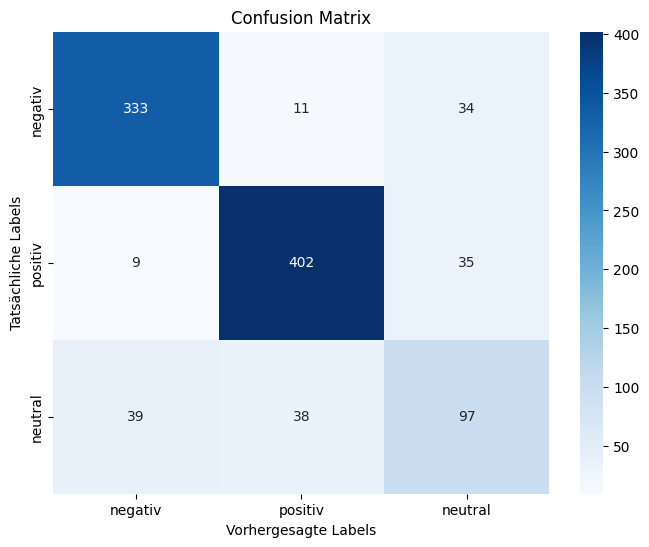

In [52]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix_gemini = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gemini, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()